BERT FOR REGRESSION 

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
import re
import bz2
import pandas as pd
import spacy
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.metrics import mean_squared_error, r2_score, mean_squared_error, mean_absolute_error
from sklearn.metrics import classification_report
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler
import torch, gc, random, datasets
from sklearn.model_selection import train_test_split


In [10]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments

In [11]:
## READ DATA
df = pd.read_csv("animes.csv")

In [12]:
df1  = df[['title', 'synopsis', 'genre' , "score"]].copy()

In [64]:
df1.head()

,title,synopsis,genre,score
0,Haikyuu!! Second Season,following their participation at the inter-hig...,"['Comedy', 'Sports', 'Drama', 'School', 'Shoun...",8.82
1,Shigatsu wa Kimi no Uso,music accompanies the path of the human metron...,"['Drama', 'Music', 'Romance', 'School', 'Shoun...",8.83
2,Made in Abyss,the abyss—a gaping chasm stretching down into ...,"['Sci-Fi', 'Adventure', 'Mystery', 'Drama', 'F...",8.83
3,Fullmetal Alchemist: Brotherhood,"""in order for something to be obtained, someth...","['Action', 'Military', 'Adventure', 'Comedy', ...",9.23
4,Kizumonogatari III: Reiketsu-hen,after helping revive the legendary vampire kis...,"['Action', 'Mystery', 'Supernatural', 'Vampire']",8.83


In [13]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19311 entries, 0 to 19310
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   title     19311 non-null  object 
 1   synopsis  18336 non-null  object 
 2   genre     19311 non-null  object 
 3   score     18732 non-null  float64
dtypes: float64(1), object(3)
memory usage: 603.6+ KB


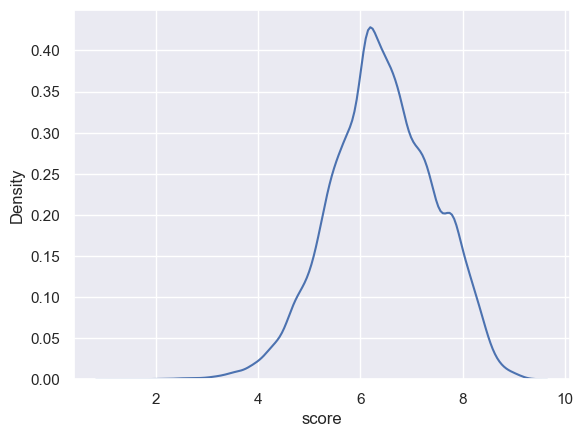

In [67]:
## PLOT THE DISTRUBUTIO OF SCORES
sns.set(style="darkgrid")
sns.kdeplot(df1['score'])
plt.show()

Looking at the above plot, score distrubution looks approximately normal. 

In [15]:
#fUNCTION TO CLEAN THE TEXT
def cleantext(text):
    
    test1 = re.sub('\r\n', '', str(text)) 
    test1 = test1.lower()
 
    
    return test1

In [16]:
### clean the text in the data and split into X and Y
df1['synopsis'] = df1['synopsis'].apply(lambda x : cleantext(x))
df2=df1.dropna(subset=['score'])
x = df2.synopsis
y = df2.score

test_size = 0.2

In [21]:
### TRAIN TEST SPLIT 
X_train, X_test, y_train, y_test = train_test_split(x.tolist(), y, test_size=test_size)


In [22]:
# SPLIT further into test and validation
X_test, X_validation, y_test, y_validation = train_test_split(X_test, y_test, test_size=0.5)


In [23]:
from transformers import BertTokenizer
from transformers import AutoTokenizer

In [24]:
### LOAD PRE-TRAINED MODEL AND PADD THE DATA
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

train_encoding = tokenizer(X_train, truncation=True, padding=True, max_length=512)
val_encoding = tokenizer(X_validation, truncation=True, padding=True, max_length=512)
test_encoding = tokenizer(X_test, truncation=True, padding=True, max_length=512)

In [25]:
# Put the data into torch form , very cool indeed
#
class TorchData(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {k: torch.tensor(v[idx]) for k, v in self.encodings.items()}
        item["labels"] = torch.tensor([self.labels[idx]])
        item["labels"] = float(item["labels"])
        return item

    def __len__(self):
        return len(self.labels)

In [26]:
### Apply torch on all the data stuff
trainDF = TorchData(train_encoding, y_train.ravel())
ValDF = TorchData(val_encoding, y_validation.ravel())
testDF = TorchData(test_encoding, y_test.ravel())

In [27]:
## Set up model 
model = AutoModelForSequenceClassification.from_pretrained("bert-base-uncased",  num_labels = 1)
#.to("cuda")

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [16]:
## CHHECK SIZE OF MODEL 
param_size = 0
for param in model.parameters():
    param_size += param.nelement() * param.element_size()
buffer_size = 0
for buffer in model.buffers():
    buffer_size += buffer.nelement() * buffer.element_size()

size_all_mb = (param_size + buffer_size) / 1024**2
print('model size: {:.3f}MB'.format(size_all_mb))


model size: 417.652MB


In [41]:
#CREATE EMPTY LISTS 
MSE_list = []
rmse_list = []
Mae_list = []
r2_list = []


In [42]:
# DEFINE METRIC FUNCTION

def compute_metrics_for_regression(eval_pred):
    logits, labels = eval_pred
    labels = labels.reshape(-1, 1)

    mse = mean_squared_error(labels, logits)
    rmse = mean_squared_error(labels, logits, squared=False)
    mae = mean_absolute_error(labels, logits)
    r2 = r2_score(labels, logits)
    smape = 1/len(labels) * np.sum(2 * np.abs(logits-labels) / (np.abs(labels) + np.abs(logits))*100)
    MSE_list.append(mse)
    rmse_list.append(rmse)
    Mae_list.append(mae)
    r2_list.append(r2)

    
    
    

    return {"mse": mse, "rmse": rmse, "mae": mae, "r2": r2, "smape": smape}

In [43]:
#DEFINE TRAINING ARGUMENTS 
training_args = TrainingArguments(
    output_dir ='./results',          
    num_train_epochs = 30,      
    per_device_train_batch_size =1,   
    per_device_eval_batch_size = 1,   
    weight_decay = 0.01,               
    learning_rate = 2e-5,
    logging_dir = './logs',            
    save_total_limit = 10,
    load_best_model_at_end = True,     
    metric_for_best_model = 'rmse',    
    evaluation_strategy = "epoch",
    save_strategy = "epoch",
) 
# DEFINE TRAINING
trainer = Trainer(
    model = model,                         
    args = training_args,                  
    train_dataset = trainDF,         
    eval_dataset = ValDF,          
    compute_metrics = compute_metrics_for_regression,     
)


PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


In [44]:
# TRAIN MODEL
trainer.train()

# Call SUMMARY
trainer.evaluate()

C:\Users\bernd\miniconda3\envs\myenv\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 14985
  Num Epochs = 30
  Instantaneous batch size per device = 1
  Total train batch size (w. parallel, distributed & accumulation) = 1
  Gradient Accumulation steps = 1
  Total optimization steps = 449550
  Number of trainable parameters = 109483009


Epoch,Training Loss,Validation Loss,Mse,Rmse,Mae,R2,Smape
1,0.375100,0.527847,0.527847,0.726531,0.545163,0.486409,8.744805
2,0.362500,0.479136,0.479136,0.692197,0.517212,0.533804,8.344272
3,0.294100,0.483270,0.483270,0.695176,0.514883,0.529782,8.362081
4,0.202000,0.480769,0.480769,0.693375,0.499354,0.532215,8.090955
5,0.217700,0.551276,0.551276,0.742480,0.544725,0.463613,8.744833
6,0.174700,0.459764,0.459764,0.678059,0.490661,0.552653,7.969144
7,0.146700,0.539062,0.539062,0.734208,0.527224,0.475497,8.419352
8,0.132000,0.509154,0.509154,0.713550,0.513616,0.504597,8.322664
9,0.130400,0.454254,0.454254,0.673983,0.481517,0.558015,7.802208
10,0.121200,0.481684,0.481684,0.694034,0.492275,0.531325,8.003804


***** Running Evaluation *****
  Num examples = 1874
  Batch size = 1
Saving model checkpoint to ./results\checkpoint-14985
Configuration saved in ./results\checkpoint-14985\config.json
Model weights saved in ./results\checkpoint-14985\pytorch_model.bin
***** Running Evaluation *****
  Num examples = 1874
  Batch size = 1
Saving model checkpoint to ./results\checkpoint-29970
Configuration saved in ./results\checkpoint-29970\config.json
Model weights saved in ./results\checkpoint-29970\pytorch_model.bin
***** Running Evaluation *****
  Num examples = 1874
  Batch size = 1
Saving model checkpoint to ./results\checkpoint-44955
Configuration saved in ./results\checkpoint-44955\config.json
Model weights saved in ./results\checkpoint-44955\pytorch_model.bin
***** Running Evaluation *****
  Num examples = 1874
  Batch size = 1
Saving model checkpoint to ./results\checkpoint-59940
Configuration saved in ./results\checkpoint-59940\config.json
Model weights saved in ./results\checkpoint-59940\py

{'eval_loss': 0.5512757897377014,
 'eval_mse': 0.5512757897377014,
 'eval_rmse': 0.7424795031547546,
 'eval_mae': 0.5447254180908203,
 'eval_r2': 0.4636127955656115,
 'eval_smape': 8.744832660752401,
 'eval_runtime': 31.144,
 'eval_samples_per_second': 60.172,
 'eval_steps_per_second': 60.172,
 'epoch': 30.0}

In [131]:
#MANUALLY SAVE THE TRAINING AND VALIDATION LOSS FOR PLOTS
training_loss = [0.375100, 0.362500 , 0.294100 , 0.202000, 0.217700, 0.174700 , 0.146700 , 0.132000 ,  0.130400, 0.121200 , 0.097900 , 0.081700, 0.099300 , 0.079700 , 0.114700 ,0.068500 , 0.070500 , 0.079200 , 0.064300 , 0.099000 , 0.055600 , 0.053600, 0.060900,0.053100 , 0.051500 , 0.075600 , 0.068100 , 0.038500, 0.044800 , 0.071300 ]
validation_loss = [0.527847 , 0.479136 , 0.483270 , 0.480769 , 0.551276 , 0.459764 , 0.539062 , 0.509154 , 0.454254 , 0.481684 , 0.447548 , 0.440874 , 0.431973 , 0.425005 , 0.434323 , 0.415787 , 0.448144 , 0.431591 , 0.424054 , 0.417414 , 0.431382 , 0.417422 , 0.413620 , 0.407910 , 0.415966 , 0.411498 , 0.422448 , 0.418930, 0.416078  , 0.418848] 
plotDF = pd.DataFrame({"TrainingLoss" :  training_loss , "ValidationLoss" : validation_loss })
plotDF["Epochs"] = range(1,31)
plotDF["MSE"] = MSE_list[2:]
plotDF["RMSE"] = rmse_list[2:]
plotDF["MAE"] = Mae_list[2:]
plotDF["R2"] = r2_list[2:]

<AxesSubplot: >

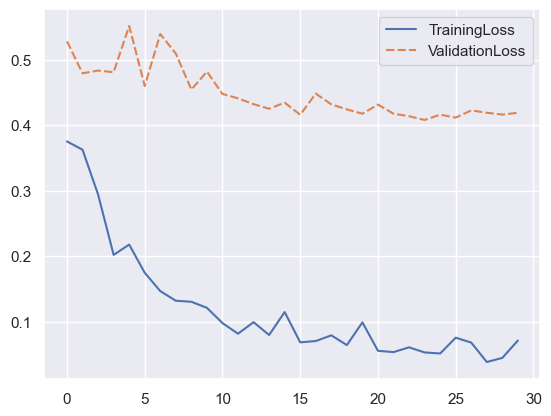

In [123]:
#PLOT
sns.lineplot(data=plotDF[['TrainingLoss', 'ValidationLoss']])


<AxesSubplot: >

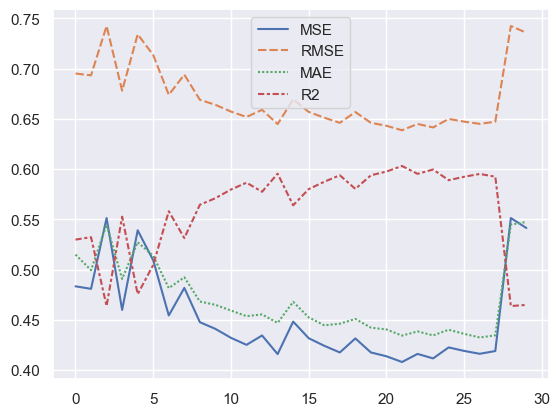

In [132]:
#plot
sns.lineplot(data=plotDF[['MSE', 'RMSE' , "MAE" , "R2" ]])


In [ ]:
pred1 = trainer.predict(testDF)

***** Running Prediction *****
  Num examples = 1873
  Batch size = 1


In [144]:
predictions = np.array(pred1[0])

In [150]:
test1 = np.array(y_test)

In [161]:
y_Test = np.array( np.expand_dims(test1, axis=1).shape)

In [208]:
test123 = np.array(y_test)
predTest = np.squeeze(predictions)
np.sum(np.square(test123 - predTest))/len(predictions)

0.5413168127263185

In [236]:
mean_squared_error(test123 , predTest  )

0.5413168127263185

In [210]:
mean_squared_error(test123 , predTest , squared =False )

0.7357423548541422

In [211]:
mean_absolute_error(test123 , predTest  )

0.5473752143786543

In [212]:
r2_score(test123, predTest )


0.46478018811110033

In [215]:
Ymean = np.mean(y_train) 

In [230]:
yMeanVec = np.full(shape=len(test123), fill_value=Ymean)

In [216]:
##### BASELIIIIIIINES 
np.sum(np.square(test123 - Ymean))/len(predictions)

1.0149098535254424

In [233]:
mean_squared_error(test123 , yMeanVec , squared =False )

1.007427344042955

In [234]:
mean_absolute_error(test123 , yMeanVec  )

0.7943936942815747

In [235]:
r2_score(test123, yMeanVec )


-0.003478643407130999